# Quickstart

This package is meant to get you from chromatogram to quantified peaks as rapidly 
as possible. Below is a brief example of how to go from a raw, off-the-machine 
data set to a list of compounds and their absolute concentrations.   

## Loading and viewing chromatograms
Text files containing chromatograms with time and signal information can be intelligently read into a pandas DataFrame using `hplc.io.load_chromatogram()`.

In [23]:
# Load the chromatogram as a dataframe
import hplc.io
df = hplc.io.load_chromatogram('data/sample.txt', 
                                 colnames=['R.Time (min)', 'Intensity'])
df.head()

,R.Time (min),Intensity
0,0.00000,0
1,0.00833,0
2,0.01667,0
3,0.02500,0
4,0.03333,-1


By providing the column names as a dictionary, you can rename the (often annoying)
default column names to something easier to work with, such as "time" and "signal"
as 

In [24]:
# Load chromatogram and rename the columns
df = hplc.io.load_chromatogram('data/sample.txt', colnames={'R.Time (min)':'time',
                                                              'Intensity': 'signal'})
df.head()

,time,signal
0,0.00000,0
1,0.00833,0
2,0.01667,0
3,0.02500,0
4,0.03333,-1


This dataframe can now be loaded passed to the `Chromatogram` class, which 
has a variety of methods for quantification, cropping, and visualization and
more.

[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

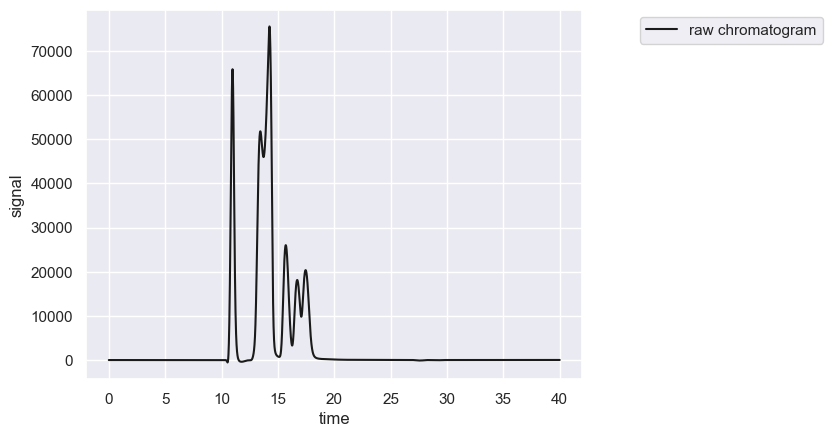

In [25]:
# Instantiate the Chromatogram class with the loaded chromatogram.
import hplc.quant
chrom = hplc.quant.Chromatogram(df)

# Show the chromatogram
chrom.show()


The `crop` method allows you to crop the chromatogram *in place* to restrict
the signal to a specific time range.  


[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

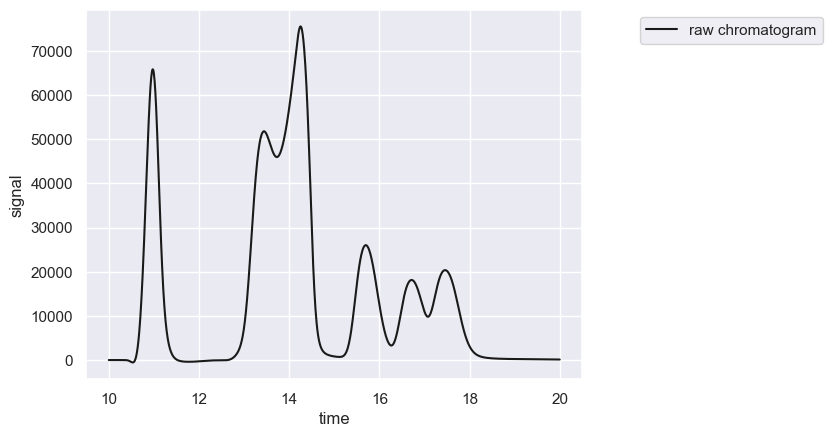

In [26]:
# Crop the chromatogram in place between 8 and 21 min.
chrom.crop([10, 20])
chrom.show()

Note that the crop function operates **in place** and modifies the loaded as data
within the `Chromatogram` object.

## 

# Detecting and Quantifying Peaks
The real meat of the package comes in the deconvolution of signal into discrete
peaks and measurement of their properties. Described in more detail in **XXX**,
this typically involves the automated estimation and subtraction of the baseline,
detection of peaks, and fitting of skew-normal distributions to reconstitute the 
signal. Luckily for you, all of this is done in a single method call `Chromatogram.fit_peaks()`

In [27]:
# Automatically detect and fit the peaks 
peaks = chrom.fit_peaks()
peaks

Deconvolving mixture: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]


,retention_time,scale,skew,amplitude,area,peak_id
0,10.904346,0.157576,0.677681,23248.375233,2.789805e+06,1
0,13.170582,0.582447,3.836861,42222.313082,5.066678e+06,2
0,14.447599,0.353161,-3.019937,35249.388929,4.229927e+06,3
0,15.531862,0.312374,1.629658,14881.173269,1.785741e+06,4
0,16.522672,0.342696,1.969566,10736.906034,1.288429e+06,5
0,17.293670,0.341221,1.616547,12411.399410,1.489368e+06,6


To see how well the deconvolution worked, you can once again call the `show` method
to see the composite compound chromatograms.

[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

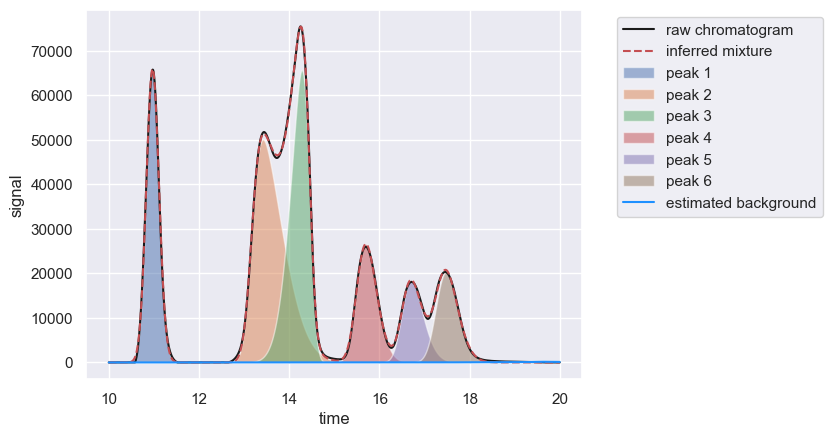

In [28]:
# View the result of the fitting. 
chrom.show()

If you know the parameters of the linear calibration curve, which relates peak area
to a known concentration, you can use the `map_compounds` method which will map user provided compound names 
to peaks.

In [29]:
# Define the two peaks of interest and their calibration curves
calibration = {'compound A': {'retention_time': 15.5,
                              'slope': 10547.6,
                              'intercept': -205.6,
                              'unit': 'µM'},
               'compound B': {'retention_time': 17.2,
                              'slope': 26401.2,
                              'intercept': 54.2,
                              'unit': 'nM'}}
quant_peaks = chrom.map_peaks(calibration)
quant_peaks

,retention_time,scale,skew,amplitude,area,peak_id,compound,concentration,unit
0,15.531862,0.312374,1.629658,14881.173269,1.785741e+06,4,compound A,169.322537,µM
0,17.293670,0.341221,1.616547,12411.399410,1.489368e+06,6,compound B,56.410835,nM


Successfully mapping compounds to peak ID's will also be reflected in the `show`
method.

[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

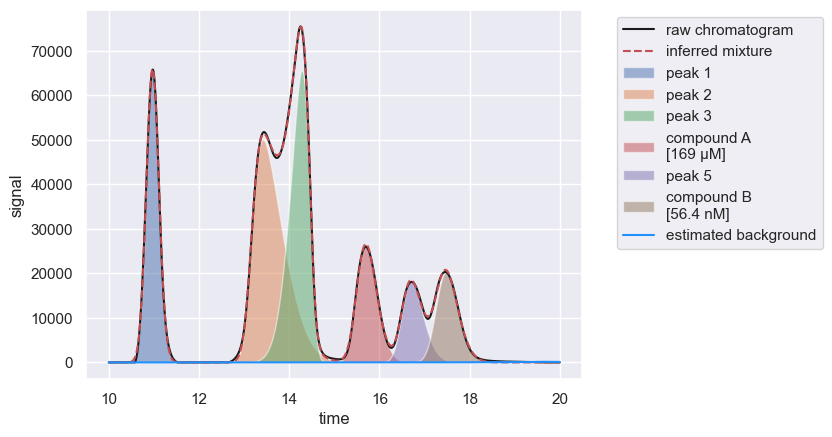

In [30]:
# Show the chromatogram with mapped compounds
chrom.show()

## Deconvolving Heavily-Overlapping Peaks
Often, compounds will have similar retention times leading to heavily overlapping peaks. If one of the compounds dominates the signal, the other compounds may only show up as a "shoulder" on the predominant peak. In this case, automatic peak detection will fail and will fit only a single peak, as in the following example.

Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00, 99.84it/s]


[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

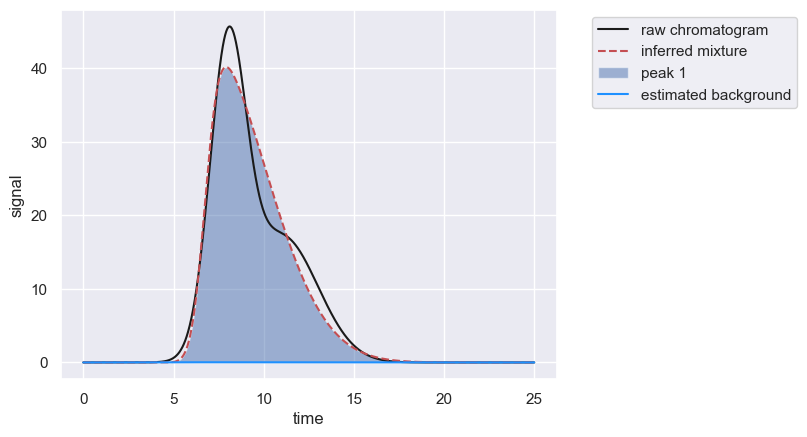

In [31]:
# Load, fit, and display a chromatogram with heavily overlapping peaks
df = hplc.io.load_chromatogram('data/example_overlap.txt', colnames=['time', 'signal'])
chrom =  hplc.quant.Chromatogram(df)
peaks = chrom.fit_peaks()
chrom.show()

However, if you *know* there is a second peak, and you know its approximate retention time, you can manually add an approximate peak position, forcing the algorithm to 
estimate the peak convolution including more than one peak.

Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

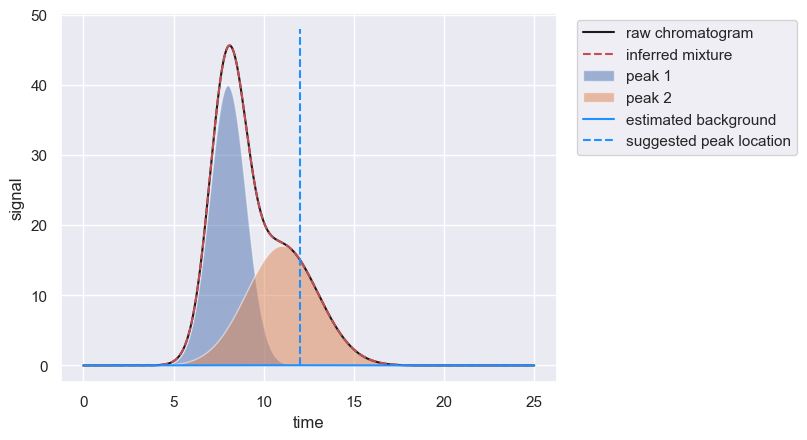

In [33]:
# Enforce a manual peak position at around 11 time units
peaks = chrom.fit_peaks(enforced_locations=[12])
chrom.show()

Note that even though we provided a guess of ≈ 12 time units for the position of the second peak, the algorithm did not force the peak to be exactly there. If `enforced_locations` are 
provided, these are used as initial guesses when performing the fitting.

This approach can also be used if there is a shallow, isolated peak that is not
automatically detected.

Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00, 103.91it/s]


[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

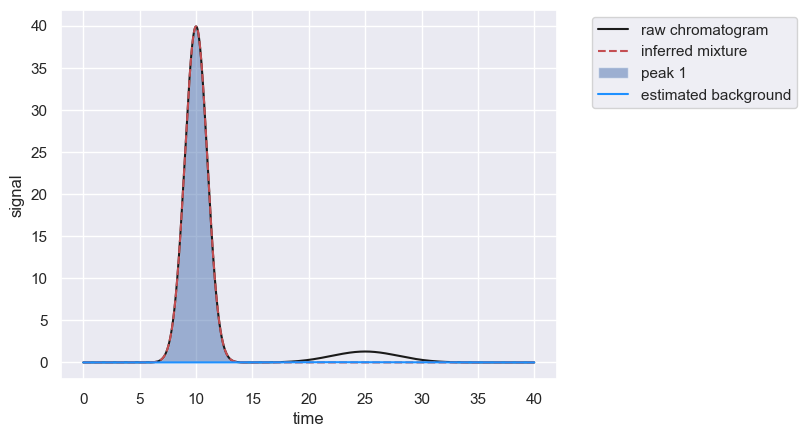

In [20]:
# Load and fit a sample with a shallow peak
df = hplc.io.load_chromatogram('data/example_shallow.csv', colnames=['time', 'signal'])
chrom = hplc.quant.Chromatogram(df)
peaks = chrom.fit_peaks(prominence=0.5) # Prominence is to exclude shallow peak
chrom.show()


As the second peak is broad, you can provide an estimate of the width of the peak at the half maximum value 
to provide a better initial guess.

Deconvolving mixture: 100%|██████████| 2/2 [00:00<00:00, 106.95it/s]


[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

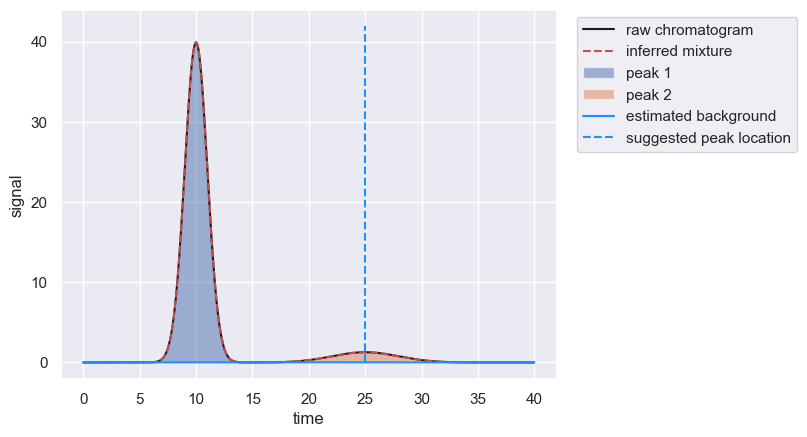

In [21]:
# Add the location of the second peak
peaks = chrom.fit_peaks(enforced_locations=[25], enforced_widths=[5], prominence=0.5)
chrom.show()